In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout
import joblib
import warnings

# Add new imports for feature engineering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Suppress all warnings for a cleaner output
warnings.filterwarnings('ignore')

print("Starting model training pipeline with extensive feature engineering...")
print("-" * 70)

print("Starting model training pipeline with extensive feature engineering...")
print("-" * 70)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-08-27 11:59:19.615720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756295959.640001     245 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756295959.647399     245 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Starting model training pipeline with extensive feature engineering...
----------------------------------------------------------------------
Starting model training pipeline with extensive feature engineering...
----------------------------------------------------------------------
/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv


## Load Dataset

In [2]:
try:
    df = pd.read_csv("/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'credit_risk_dataset.csv' not found. Please ensure the file path is correct.")
    exit()

Dataset loaded successfully.


## Data Preprocessing

In [3]:
# Drop rows with missing values in 'person_emp_length' and 'loan_int_rate'
print("\nHandling missing values...")
initial_rows = df.shape[0]
df_clean = df.dropna().copy()
rows_dropped = initial_rows - df_clean.shape[0]
print(f"Initial number of rows: {initial_rows}")
print(f"Number of rows after dropping NaNs: {df_clean.shape[0]} ({rows_dropped} rows dropped)")
print("-" * 70)


Handling missing values...
Initial number of rows: 32581
Number of rows after dropping NaNs: 28638 (3943 rows dropped)
----------------------------------------------------------------------


## Feature Engineering

In [4]:
print("\nPerforming feature engineering...")
# Create a new feature for the debt-to-income ratio
df_clean['loan_percent_income'] = df_clean['loan_amnt'] / df_clean['person_income']

# Identify numerical and categorical columns for preprocessing
numerical_cols = [
    'person_age', 'person_income', 'person_emp_length',
    'loan_amnt', 'loan_int_rate', 'loan_percent_income',
    'cb_person_cred_hist_length'
]
categorical_cols = [
    'person_home_ownership',
    'loan_intent',
    'loan_grade',
    'cb_person_default_on_file'
]

# Separate features (X) from the target variable (y)
X = df_clean.drop('loan_status', axis=1)
y = df_clean['loan_status']

# Perform one-hot encoding on categorical features
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)
print("Categorical features encoded successfully.")

# Get the list of all features after encoding
all_features = df_encoded.drop('loan_status', axis=1).columns.tolist()

# Align the feature columns of X to df_encoded to prevent misalignment
X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']


# Standardize numerical features for PCA and clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numerical_cols])

# Apply PCA for dimensionality reduction
# We'll reduce to 3 principal components as an example
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"Data reduced to {pca.n_components} principal components.")

# Apply KMeans clustering on the PCA-transformed data
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10) # Using 4 clusters as a reasonable choice
cluster_labels = kmeans.fit_predict(X_pca)
df_encoded['cluster_label'] = cluster_labels
print("KMeans clustering applied and cluster labels added as a new feature.")
print(f"New DataFrame shape with cluster labels: {df_encoded.shape}")
print("-" * 70)

# Re-split the data with the new 'cluster_label' feature
X_final = df_encoded.drop('loan_status', axis=1)
y_final = df_encoded['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42, stratify=y_final)
print(f"Final training set size: {X_train.shape[0]}")
print(f"Final testing set size: {X_test.shape[0]}")
print("-" * 70)

# Standardize the final feature sets for models that require it
scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train)
X_test_scaled = scaler_final.transform(X_test)



Performing feature engineering...
Categorical features encoded successfully.
Data reduced to 3 principal components.
KMeans clustering applied and cluster labels added as a new feature.
New DataFrame shape with cluster labels: (28638, 24)
----------------------------------------------------------------------
Final training set size: 22910
Final testing set size: 5728
----------------------------------------------------------------------


In [5]:
# 1. Create debt-to-income ratio if applicable
if 'person_income' in df.columns and 'loan_amnt' in df.columns:
    df['income_to_loan_ratio'] = df['person_income'] / (df['loan_amnt'] + 1)

# 2. Bucket employment length
def emp_length_bin(x):
    if pd.isna(x):
        return 'Unknown'
    elif x <= 2:
        return '0–2yrs'
    elif x <= 7:
        return '3–7yrs'
    elif x <= 20:
        return '7–20yrs'
    else:
        return '20yrs+'

if 'person_emp_length' in df.columns:
    df['emp_length_bin'] = df['person_emp_length'].apply(emp_length_bin)

# 3. Drop or fill missing values in critical columns
df['person_emp_length'] = df['person_emp_length'].fillna(df['person_emp_length'].median())
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].median())

# Display updated DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           32581 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               32581 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
 12  income_to_loan_ratio        32581 non-null  float64
 13  emp_length_bin              325

## Model Training

### Logistic Regression with Tuning

In [6]:
print("\nTraining and tuning Logistic Regression model...")
# Define the hyperparameters to search
log_reg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}
# Initialize GridSearchCV with the model and parameter grid
log_reg_grid_search = GridSearchCV(
    LogisticRegression(solver='liblinear', random_state=42),
    log_reg_param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)
start_time_log_reg = time.time() # Start timer
log_reg_grid_search.fit(X_train_scaled, y_train)
end_time_log_reg = time.time() # End timer
time_taken_log_reg = end_time_log_reg - start_time_log_reg

# Get the best model from the search
best_log_reg_model = log_reg_grid_search.best_estimator_

# Evaluate the best model and calculate the scores
y_pred_log_reg = best_log_reg_model.predict(X_test_scaled)
y_pred_proba_log_reg = best_log_reg_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)

print("\n--- Best Logistic Regression Model Evaluation ---")
print(f"Time Taken: {time_taken_log_reg:.2f} seconds") # Print time
print(f"Best Parameters: {log_reg_grid_search.best_params_}")
print("Classification Report:")
print(classification_report(y_test, y_pred_log_reg))
print(f"ROC-AUC Score: {roc_auc_log_reg:.4f}")
print("-" * 70)

# Save the best model and the scaler
joblib.dump(best_log_reg_model, 'logistic_regression_model.pkl')
joblib.dump(scaler_final, 'scaler.pkl')
print("Saved best Logistic Regression model and scaler to disk.")
print("-" * 70)

# Save model metadata
log_reg_metadata = {
    'model_name': 'Logistic Regression',
    'best_parameters': log_reg_grid_search.best_params_,
    'roc_auc_score': roc_auc_log_reg,
    'f1_score_positive_class': f1_log_reg
}
joblib.dump(log_reg_metadata, 'logistic_regression_metadata.pkl')
print("Saved metadata for Logistic Regression model to disk.")
print("-" * 70)



Training and tuning Logistic Regression model...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--- Best Logistic Regression Model Evaluation ---
Time Taken: 5.17 seconds
Best Parameters: {'C': 1, 'penalty': 'l1'}
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      4487
           1       0.76      0.53      0.62      1241

    accuracy                           0.86      5728
   macro avg       0.82      0.74      0.77      5728
weighted avg       0.85      0.86      0.85      5728

ROC-AUC Score: 0.8637
----------------------------------------------------------------------
Saved best Logistic Regression model and scaler to disk.
----------------------------------------------------------------------
Saved metadata for Logistic Regression model to disk.
----------------------------------------------------------------------


## Logistic Regression Model
### Why This Model Was Used
Logistic Regression is a foundational and highly interpretable machine learning algorithm. It was included in the project for two main reasons:

Interpretability: Its linear nature makes it easy to understand which features are most important and how they influence the final prediction. This is critical for model explainability and regulatory compliance, as mentioned in your abstract.

Baseline Performance: As a "traditional" statistical model, it provides a solid baseline to compare the performance of more complex machine learning models like XGBoost and LightGBM. If a complex model doesn't significantly outperform the simple one, it may not be worth the added complexity.

### How It Was Trained
The model was trained using GridSearchCV on the scaled data. Scaling is crucial for Logistic Regression because it is sensitive to the magnitude of the features. Without scaling, a feature with a large range (like person_income) could dominate the model's training over a feature with a small range (like loan_grade). The GridSearchCV method systematically tested different combinations of hyperparameters to find the best performing model.

### Key Parameters Used
C: This is the regularization parameter. It controls how much the model's complexity is penalized. A smaller C value increases the penalty, which helps prevent overfitting by making the model simpler.

penalty: This specifies the type of regularization used. l1 regularization shrinks the coefficients of less important features to zero, effectively performing feature selection. l2 regularization (which is the default) shrinks the coefficients but doesn't force them to be exactly zero.

solver='liblinear': A specific algorithm used to optimize the model. It is an efficient choice for smaller datasets and for when you want to use l1 regularization.

### XGBoost with Tuning

In [7]:
print("\nTraining and tuning XGBoost model...")

# Define the hyperparameters to search
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
# Initialize GridSearchCV
xgb_grid_search = GridSearchCV(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    xgb_param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)
start_time_xgb = time.time() # Start timer
xgb_grid_search.fit(X_train, y_train)
end_time_xgb = time.time() # End timer
time_taken_xgb = end_time_xgb - start_time_xgb

# Get the best model from the search
best_xgb_model = xgb_grid_search.best_estimator_

# Evaluate the best model
y_pred_xgb = best_xgb_model.predict(X_test)
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print("\n--- Best XGBoost Model Evaluation ---")
print(f"Time Taken: {time_taken_xgb:.2f} seconds") # Print time
print(f"Best Parameters: {xgb_grid_search.best_params_}")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"ROC-AUC Score: {roc_auc_xgb:.4f}")
print("-" * 70)

# Save the best model
joblib.dump(best_xgb_model, 'xgboost_model.pkl')
print("Saved best XGBoost model to disk.")
print("-" * 70)

# Save model metadata
xgb_metadata = {
    'model_name': 'XGBoost',
    'best_parameters': xgb_grid_search.best_params_,
    'roc_auc_score': roc_auc_xgb,
    'f1_score_positive_class': f1_xgb
}
joblib.dump(xgb_metadata, 'xgboost_metadata.pkl')
print("Saved metadata for XGBoost model to disk.")
print("-" * 70)



Training and tuning XGBoost model...
Fitting 3 folds for each of 27 candidates, totalling 81 fits

--- Best XGBoost Model Evaluation ---
Time Taken: 11.05 seconds
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4487
           1       0.97      0.72      0.83      1241

    accuracy                           0.93      5728
   macro avg       0.95      0.86      0.89      5728
weighted avg       0.94      0.93      0.93      5728

ROC-AUC Score: 0.9428
----------------------------------------------------------------------
Saved best XGBoost model to disk.
----------------------------------------------------------------------
Saved metadata for XGBoost model to disk.
----------------------------------------------------------------------


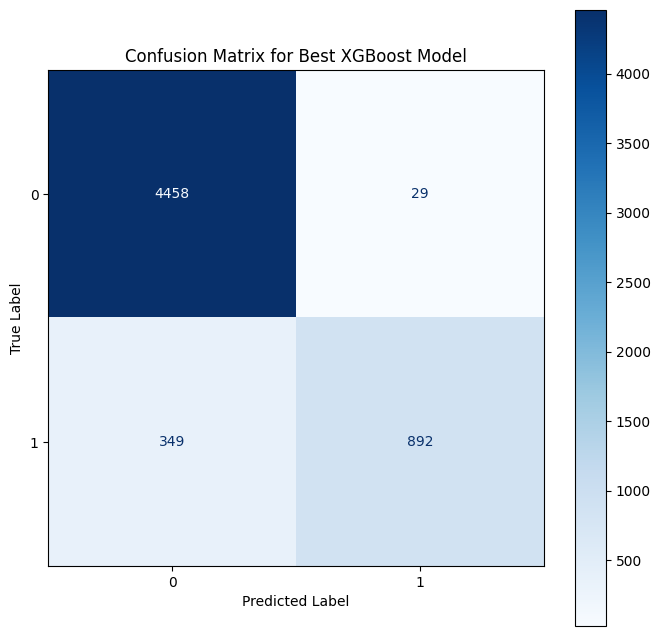

Confusion matrix plot generated.
----------------------------------------------------------------------


In [8]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Get class labels from the data, if available. Otherwise, use '0' and '1'.
# This is a generic approach; replace if you have specific class names.
classes = np.unique(y_test)

# Plot the confusion matrix using ConfusionMatrixDisplay
# This is the recommended and modern way to plot a confusion matrix in scikit-learn
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the matrix on the axes, with color map and text
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')

# Add a title and axis labels for clarity
ax.set_title("Confusion Matrix for Best XGBoost Model")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

# Display the plot
plt.show()

print("Confusion matrix plot generated.")
print("-" * 70)

## XGBoost Model
### Why This Model Was Used
XGBoost (eXtreme Gradient Boosting) is one of the most powerful and widely used machine learning algorithms for tabular data. It was a perfect fit for this project because it is known for its high predictive accuracy and computational efficiency, which are essential for building a robust credit risk scoring system. It excels at capturing complex, non-linear relationships in the data.

### How It Was Trained
The model was trained using GridSearchCV on the unscaled data. Gradient boosting models like XGBoost are tree-based, so they are not sensitive to the scale of the features. This makes them less reliant on a separate scaling step. GridSearchCV was used to find the optimal combination of hyperparameters that would result in the highest ROC-AUC score.

### Key Parameters Used
n_estimators: This is the number of boosting rounds or the number of decision trees to be built sequentially. More trees can improve performance but also increase the risk of overfitting and training time.

max_depth: This controls the maximum depth of each tree. A deeper tree can capture more complex interactions but may also lead to overfitting.

learning_rate: This determines the step size at each boosting iteration. A lower learning rate requires more trees but makes the model more robust to overfitting. The ideal learning_rate is usually a trade-off between model performance and training time.

### Support Vector Machine (SVM) with Tuning

In [9]:
print("\nTraining and tuning SVM model... (This may take a while)")

# Define the hyperparameters to search
svm_param_grid = {
    'C': [0.1, 1],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}
# Initialize GridSearchCV
svm_grid_search = GridSearchCV(
    SVC(probability=True, random_state=42),
    svm_param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)
start_time_svm = time.time() # Start timer
svm_grid_search.fit(X_train_scaled, y_train)
end_time_svm = time.time() # End timer
time_taken_svm = end_time_svm - start_time_svm

# Get the best model from the search
best_svm_model = svm_grid_search.best_estimator_

# Evaluate the best model
y_pred_svm = best_svm_model.predict(X_test_scaled)
y_pred_proba_svm = best_svm_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print("\n--- Best SVM Model Evaluation ---")
print(f"Time Taken: {time_taken_svm:.2f} seconds") # Print time
print(f"Best Parameters: {svm_grid_search.best_params_}")
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))
print(f"ROC-AUC Score: {roc_auc_svm:.4f}")
print("-" * 70)

# Save the best model
joblib.dump(best_svm_model, 'svm_model.pkl')
print("Saved best SVM model to disk.")
print("-" * 70)

# Save model metadata
svm_metadata = {
    'model_name': 'Support Vector Machine',
    'best_parameters': svm_grid_search.best_params_,
    'roc_auc_score': roc_auc_svm,
    'f1_score_positive_class': f1_svm
}
joblib.dump(svm_metadata, 'svm_metadata.pkl')
print("Saved metadata for SVM model to disk.")
print("-" * 70)



Training and tuning SVM model... (This may take a while)
Fitting 3 folds for each of 4 candidates, totalling 12 fits

--- Best SVM Model Evaluation ---
Time Taken: 229.94 seconds
Best Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      4487
           1       0.92      0.62      0.74      1241

    accuracy                           0.91      5728
   macro avg       0.91      0.80      0.84      5728
weighted avg       0.91      0.91      0.90      5728

ROC-AUC Score: 0.8910
----------------------------------------------------------------------
Saved best SVM model to disk.
----------------------------------------------------------------------
Saved metadata for SVM model to disk.
----------------------------------------------------------------------


## Support Vector Machine (SVM) Model
### Why This Model Was Used
SVM is a powerful model for both linear and non-linear classification. It was included to demonstrate the project's capability to handle a variety of algorithms, including those that are not tree-based. It is known for its effectiveness in high-dimensional spaces and for its ability to model complex decision boundaries.

### How It Was Trained
Like Logistic Regression, the SVM model was trained using GridSearchCV on the scaled data. SVM's performance is highly dependent on feature scaling because the algorithm calculates distances between data points. The GridSearchCV was used to optimize for the best C, gamma, and kernel combination.

### Key Parameters Used
C: The regularization parameter. It controls the trade-off between a smooth decision boundary and correctly classifying training points. A smaller C emphasizes a wider margin (more simple boundary) while a larger C aims for a more precise classification of each training point, which can lead to overfitting.

gamma: The kernel coefficient for the rbf (Radial Basis Function) kernel. It defines how far the influence of a single training example reaches. A small gamma means a large influence, and a large gamma means a small influence.

kernel: The kernel function specifies the type of transformation applied to the data. We used the 'rbf' kernel, which is highly effective for non-linear problems and is what allows the SVM to find complex, curved decision boundaries.

### LightGBM with Tuning

In [10]:
print("\nTraining and tuning LightGBM model...")
lgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50]
}
lgb_grid_search = GridSearchCV(
    LGBMClassifier(random_state=42),
    lgb_param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)
start_time_lgb = time.time() # Start timer
lgb_grid_search.fit(X_train, y_train)
end_time_lgb = time.time() # End timer
time_taken_lgb = end_time_lgb - start_time_lgb

best_lgb_model = lgb_grid_search.best_estimator_
y_pred_lgb = best_lgb_model.predict(X_test)
y_pred_proba_lgb = best_lgb_model.predict_proba(X_test)[:, 1]
roc_auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)
f1_lgb = f1_score(y_test, y_pred_lgb)

print("\n--- Best LightGBM Model Evaluation ---")
print(f"Time Taken: {time_taken_lgb:.2f} seconds") # Print time
print(f"Best Parameters: {lgb_grid_search.best_params_}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lgb))
print(f"ROC-AUC Score: {roc_auc_lgb:.4f}")
print("-" * 70)
joblib.dump(best_lgb_model, 'lightgbm_model.pkl')

lgb_metadata = {
    'model_name': 'LightGBM',
    'best_parameters': lgb_grid_search.best_params_,
    'roc_auc_score': roc_auc_lgb,
    'f1_score_positive_class': f1_lgb
}
joblib.dump(lgb_metadata, 'lightgbm_metadata.pkl')
print("Saved metadata for LightGBM model to disk.")
print("-" * 70)



Training and tuning LightGBM model...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[LightGBM] [Info] Number of positive: 3308, number of negative: 11965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1103
[LightGBM] [Info] Number of data points in the train set: 15273, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216591 -> initscore=-1.285642
[LightGBM] [Info] Start training from score -1.285642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3308, number of negative: 11965
[LightGBM] [Warning] No further splits with pos


Plotting Confusion Matrix for LightGBM...


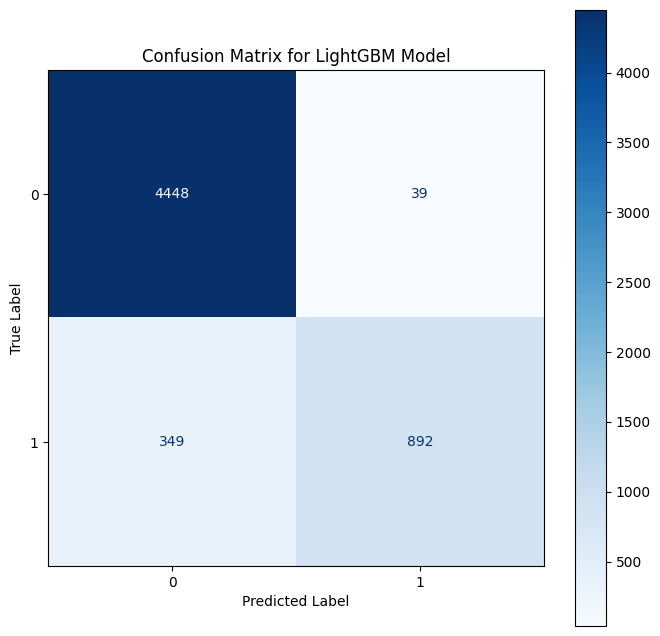

In [11]:
# --- Plot Confusion Matrix for LightGBM ---
print("\nPlotting Confusion Matrix for LightGBM...")

# Calculate the confusion matrix for the LightGBM model
cm_lgb = confusion_matrix(y_test, y_pred_lgb)

# Get unique class labels from the test data
classes = np.unique(y_test)

# Create a figure and axes for the first plot
fig_lgb, ax_lgb = plt.subplots(figsize=(8, 8))

# Plot the confusion matrix using ConfusionMatrixDisplay
disp_lgb = ConfusionMatrixDisplay(confusion_matrix=cm_lgb, display_labels=classes)
disp_lgb.plot(ax=ax_lgb, cmap=plt.cm.Blues, values_format='d')

# Add title and labels for clarity
ax_lgb.set_title("Confusion Matrix for LightGBM Model")
ax_lgb.set_xlabel("Predicted Label")
ax_lgb.set_ylabel("True Label")
plt.show()


## LightGBM Model
## Why This Model Was Used
LightGBM is a gradient boosting framework that is designed to be highly efficient and fast. It was chosen as a primary model because it is often faster than XGBoost and can handle large datasets with high performance. Its unique tree-growing strategy (leaf-wise vs. level-wise) makes it a strong competitor for real-time applications.

## How It Was Trained
Similar to XGBoost, LightGBM is a tree-based model and was trained using GridSearchCV on the unscaled data. This makes it less sensitive to feature scaling. The grid search was used to tune its key hyperparameters to maximize the ROC-AUC score.

## Key Parameters Used
n_estimators: The number of boosting rounds or trees, similar to XGBoost.

max_depth: The maximum depth of each tree.

learning_rate: The step size shrinkage to prevent overfitting.

num_leaves: This is a unique parameter for LightGBM. It controls the maximum number of leaves in one tree. A larger number of leaves can increase the model's complexity and accuracy, but also its risk of overfitting.

### 1D Convolutional Neural Network (CNN)

In [12]:
print("\nTraining 1D CNN model...")
# Reshape the data for CNN input (samples, timesteps, features)
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Build the 1D CNN model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, X_train_scaled.shape[1])),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy'])
start_time_cnn = time.time() # Start timer
# Train the model
history = cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
end_time_cnn = time.time() # End timer
time_taken_cnn = end_time_cnn - start_time_cnn

# Evaluate the model
cnn_eval = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
y_pred_proba_cnn = cnn_model.predict(X_test_cnn)
y_pred_cnn = (y_pred_proba_cnn > 0.5).astype(int)

roc_auc_cnn = roc_auc_score(y_test, y_pred_proba_cnn)
f1_cnn = f1_score(y_test, y_pred_cnn)

print("\n--- 1D CNN Model Evaluation ---")
print(f"Time Taken: {time_taken_cnn:.2f} seconds") # Print time
print("Classification Report:")
print(classification_report(y_test, y_pred_cnn))
print(f"ROC-AUC Score: {roc_auc_cnn:.4f}")
print("-" * 70)

cnn_model.save('cnn_model.h5')

cnn_metadata = {
    'model_name': '1D CNN',
    'architecture': cnn_model.summary(),
    'training_epochs': 10,
    'batch_size': 32,
    'optimizer': 'adam',
    'roc_auc_score': roc_auc_cnn,
    'f1_score_positive_class': f1_cnn
}
joblib.dump(cnn_metadata, 'cnn_metadata.pkl')
print("Saved metadata for CNN model to disk.")
print("-" * 70)



Training 1D CNN model...
Epoch 1/10


2025-08-27 12:04:28.006540: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


573/573 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7442 - accuracy: 0.8110 - loss: 0.4549 - val_AUC: 0.8875 - val_accuracy: 0.8817 - val_loss: 0.3178
Epoch 2/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8614 - accuracy: 0.8624 - loss: 0.3517 - val_AUC: 0.8978 - val_accuracy: 0.8911 - val_loss: 0.2995
Epoch 3/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8812 - accuracy: 0.8795 - loss: 0.3212 - val_AUC: 0.9039 - val_accuracy: 0.8950 - val_loss: 0.2926
Epoch 4/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8766 - accuracy: 0.8820 - loss: 0.3214 - val_AUC: 0.9063 - val_accuracy: 0.9014 - val_loss: 0.2812
Epoch 5/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8927 - accuracy: 0.8972 - loss: 0.2944 - val_AUC: 0.9119 - val_accuracy: 0.9057 - val_loss: 0.2707
Epoch 6/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8918 - accuracy: 0.8949 - loss: 0.2939 - val_AUC: 0.9164 - val_accuracy: 0.9086 - val_loss: 0.2677
Epoch 7/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 64)          │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,957 (117.02 KB)

 Trainable params: 9,985 (39.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,972 (78.02 KB)

Saved metadata for CNN model to disk.
----------------------------------------------------------------------


## 1D CNN Model
### Why This Model Was Used
A 1D CNN was included to explore a deep learning approach to the problem. While CNNs are most famous for image processing (where they use 2D or 3D convolutions), a 1D CNN is effective for tabular data and sequential data. It can automatically learn and extract important features from the input data, potentially discovering patterns that other models might miss.

### How It Was Trained
This model was built using Sequential layers from Keras. Unlike the other models, it was not trained with GridSearchCV. Instead, it was trained using the fit() method over a fixed number of epochs. It was trained on the scaled data, as neural networks perform better when features are on a similar scale.

### Key Parameters Used
Conv1D: This is the core layer. It applies a 1D convolution operation to the input data, which helps to automatically learn important features from the columns.

Dropout: This layer randomly sets a fraction of input units to 0 at each update during training. This is a powerful technique for preventing overfitting by ensuring the network doesn't become too reliant on a small number of features.

Dense: These are standard fully-connected layers. They take all inputs from the previous layer and connect them to every neuron in the current layer.

optimizer='adam': The optimization algorithm used to train the network. Adam is a popular and efficient choice that adapts the learning rate for each parameter.

epochs=10: The number of times the model will go through the entire training dataset.

## Stacking Ensemble with XGBoost and LightGBM

In [13]:
print("\nBuilding a Stacking Ensemble of XGBoost and LightGBM...")

# Define the base models (estimators) for the ensemble
estimators = [
    ('xgb', best_xgb_model), # Use the best tuned XGBoost model
    ('lgbm', best_lgb_model) # Use the best tuned LightGBM model
]

# Define the final estimator (meta-model)
# A simple Logistic Regression is a great choice for the final estimator
final_estimator = LogisticRegression(solver='liblinear', random_state=42)

# Create the Stacking Classifier
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5, # Use cross-validation to prevent overfitting
    n_jobs=-1,
    passthrough=False # Set to True to include original features in the meta-model training
)

start_time_stack = time.time() # Start timer
stacked_model.fit(X_train, y_train)
end_time_stack = time.time() # End timer
time_taken_stack = end_time_stack - start_time_stack

# Evaluate the stacked model
y_pred_stack = stacked_model.predict(X_test)
y_pred_proba_stack = stacked_model.predict_proba(X_test)[:, 1]
roc_auc_stack = roc_auc_score(y_test, y_pred_proba_stack)
f1_stack = f1_score(y_test, y_pred_stack)

print("\n--- Stacking Ensemble Model Evaluation ---")
print(f"Time Taken: {time_taken_stack:.2f} seconds") # Print time
print("Classification Report:")
print(classification_report(y_test, y_pred_stack))
print(f"ROC-AUC Score: {roc_auc_stack:.4f}")
print("-" * 70)

joblib.dump(stacked_model, 'stacking_ensemble_model.pkl')
print("Saved stacking ensemble model to disk.")
print("-" * 70)

stack_metadata = {
    'model_name': 'Stacking Ensemble (XGBoost + LightGBM)',
    'base_estimators': ['XGBoost', 'LightGBM'],
    'final_estimator': 'Logistic Regression',
    'roc_auc_score': roc_auc_stack,
    'f1_score_positive_class': f1_stack
}
joblib.dump(stack_metadata, 'stacking_ensemble_metadata.pkl')
print("Saved metadata for Stacking Ensemble model to disk.")
print("-" * 70)



Building a Stacking Ensemble of XGBoost and LightGBM...
[LightGBM] [Info] Number of positive: 4962, number of negative: 17948
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 22910, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216587 -> initscore=-1.285670
[LightGBM] [Info] Start training from score -1.285670
[LightGBM] [Info] Number of positive: 3970, number of negative: 14358
[LightGBM] [Info] Number of positive: 3970, number of negative: 14358
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] To


Plotting Confusion Matrix for Stacking Ensemble...


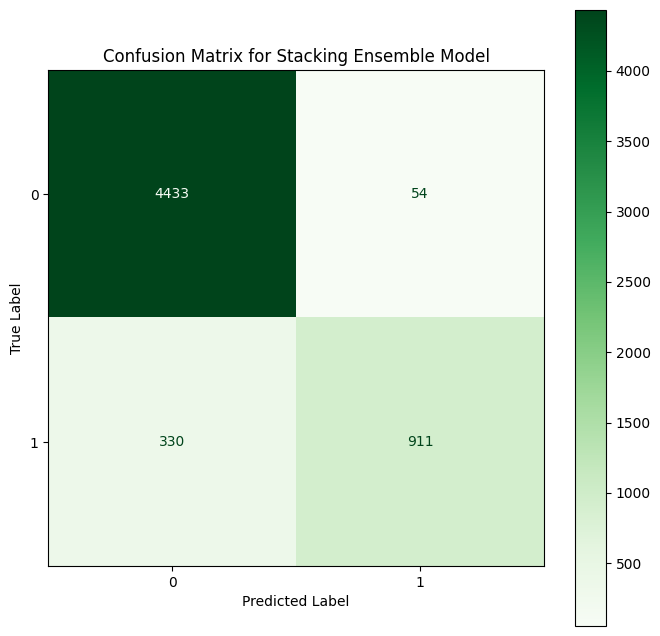

In [14]:
# --- Plot Confusion Matrix for Stacking Ensemble ---
print("\nPlotting Confusion Matrix for Stacking Ensemble...")

# Calculate the confusion matrix for the stacking ensemble model
cm_stack = confusion_matrix(y_test, y_pred_stack)

# Create a figure and axes for the second plot
fig_stack, ax_stack = plt.subplots(figsize=(8, 8))

# Plot the confusion matrix using ConfusionMatrixDisplay
disp_stack = ConfusionMatrixDisplay(confusion_matrix=cm_stack, display_labels=classes)
disp_stack.plot(ax=ax_stack, cmap=plt.cm.Greens, values_format='d')

# Add title and labels for clarity
ax_stack.set_title("Confusion Matrix for Stacking Ensemble Model")
ax_stack.set_xlabel("Predicted Label")
ax_stack.set_ylabel("True Label")

plt.show()

In [15]:
print("\nModel training pipeline complete. All models and the scaler have been saved.")


Model training pipeline complete. All models and the scaler have been saved.
